In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
from sklearn.preprocessing import OneHotEncoder,RobustScaler,FunctionTransformer
from category_encoders.target_encoder import TargetEncoder
from sklearn.metrics import *
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer,TransformedTargetRegressor
from sklearn.linear_model import *
from sklearn.ensemble import RandomForestRegressor,BaggingRegressor,AdaBoostRegressor,VotingRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV,KFold,cross_val_score
import time

## Énoncé
Travaillant pour la ville de Seattle,nous voulons tenter de prédire les émissions de CO2 et la consommation totale d’énergie de bâtiments non destinés à l’habitation.

## Mission
Nous allons tester différents modèles afin de choisir le meilleur pour la prédiction des émissions de CO2 et la consommation totale d’énergie des bâtiments non destinés à l’habitation.

Lecture des features et labels:

In [86]:
X=pd.read_csv('X.csv')
Y=pd.read_csv('Y.csv')

Aperçu des données:

In [87]:
X.head()

,BuildingType,PrimaryPropertyType,Neighborhood,NumberofBuildings,NumberofFloors,PropertyGFATotal,LargestPropertyUseType,ENERGYSTARScore,BuildingAge,GFAParkingRatio,GFABuildingRatio
0,NonResidential,Hotel/Senior Care/Housing,DOWNTOWN,1.0,12.0,88434,Hotel/Senior Care/Housing,65.0,88,0.000000,1.000000
1,NonResidential,Hotel/Senior Care/Housing,DOWNTOWN,1.0,11.0,103566,Hotel/Senior Care/Housing,51.0,19,0.145453,0.854547
2,NonResidential,Hotel/Senior Care/Housing,DOWNTOWN,1.0,41.0,961990,Hotel/Senior Care/Housing,18.0,46,0.000000,1.000000
3,NonResidential,Hotel/Senior Care/Housing,DOWNTOWN,1.0,10.0,61320,Hotel/Senior Care/Housing,1.0,89,0.000000,1.000000
4,NonResidential,Hotel/Senior Care/Housing,DOWNTOWN,1.0,18.0,119890,Hotel/Senior Care/Housing,67.0,35,0.103929,0.896071


In [88]:
Y.head()

,TotalGHGEmissions,SiteEnergyUse(kBtu)
0,249.43,6981428.0
1,263.51,8354235.0
2,2061.48,73130656.0
3,1936.34,28229320.0
4,507.70,14829099.0


Leurs tailles:

In [89]:
X.shape,Y.shape

((3317, 11), (3317, 2))

### Impact de l'échelle logarithmique

Nous allons vérifier l'impact de l'echelle logarithmique sur nos données de prédictions:

Tranformons les données à l'echelle logarithmique

In [90]:
logtransformer = FunctionTransformer(np.log, inverse_func = np.exp, check_inverse = True)
Y_log = logtransformer.transform(Y)

Comparons les graphes aux deux echelles:

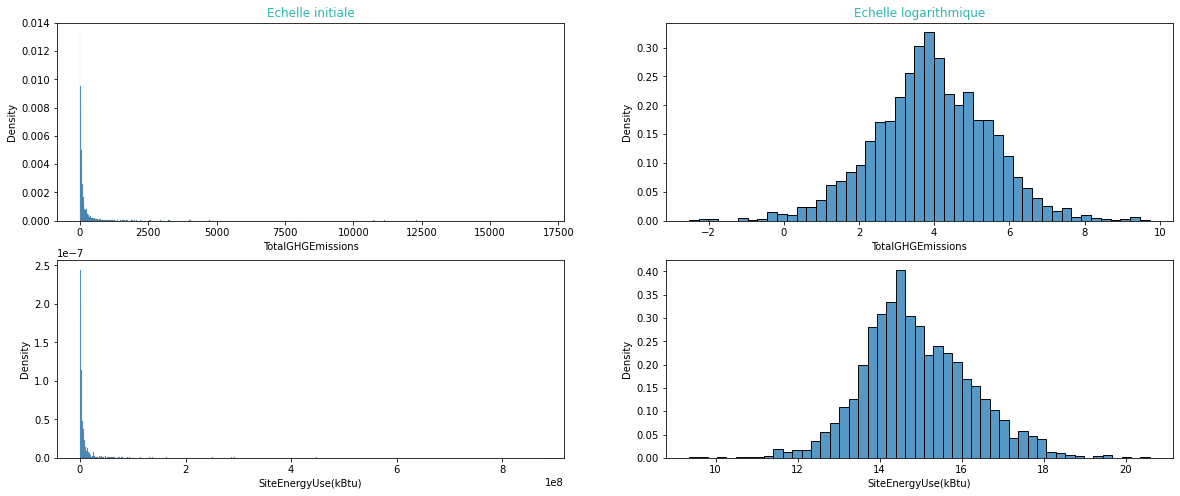

In [91]:
fig, axes = plt.subplots(nrows=2, ncols=2, sharex=False, sharey=False, figsize=(20,8))
ax=sns.histplot(data=Y, x='TotalGHGEmissions', stat="density", ax=axes[0,0])
axes[0,0].set_title("Echelle initiale", color='#2cb7b0' )
ax=sns.histplot(data=Y_log, x='TotalGHGEmissions', stat="density", ax=axes[0,1])
axes[0,1].set_title("Echelle logarithmique", color='#2cb7b0')
ax=sns.histplot(data=Y, x='SiteEnergyUse(kBtu)', stat="density", ax=axes[1,0])
ax=sns.histplot(data=Y_log, x='SiteEnergyUse(kBtu)', stat="density", ax=axes[1,1])

Nous obtenons une distribution normale des données. Nous allons donc appliquer cette transformation dans nos données de prédictions.

### Standardisation & encodage 

Nous uliserons RobustScaler et OneHotEncoder par la standardisation et l'encodage des features numériques et categorielles:

In [92]:
numerical_features = (X.select_dtypes(['int64','float64']).columns).tolist()
categorical_features = (X.select_dtypes(['object','category']).columns).tolist()
numerical_transformer = RobustScaler()
categorical_transformer = OneHotEncoder(handle_unknown = 'ignore')

Définissons un processeur executera ces operations d'encodage et standardisation:

In [93]:
preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numerical_transformer, numerical_features),
        ('categorical', categorical_transformer, categorical_features)
    ]
)


### Séparation des jeux d'entrainement et de test

Séparons nos données en entrainement et test avec une proportion de 30% pour le test:

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)

### Choix de la métrique d'évaluation des modèles

Nous allons chercher d'identifier la meilleure métrique pour évaluer nos modèles:

Définissons un pipeline pour executer les operations du proprocessor et la tranformation logarithmique pour le modèle de regression lineaire:

In [95]:
algos = {
   'LinearRegression' : make_pipeline(
        preprocessor,
        TransformedTargetRegressor(regressor=LinearRegression(), func=np.log1p, inverse_func=np.expm1)
    )
}

Listons les différentes métriques:

In [96]:
errors_types=['max_error','neg_mean_absolute_error','neg_mean_squared_error','neg_root_mean_squared_error',
       'neg_median_absolute_error','r2']
errors_types

['max_error',
 'neg_mean_absolute_error',
 'neg_mean_squared_error',
 'neg_root_mean_squared_error',
 'neg_median_absolute_error',
 'r2']

Définissons une fonction qui calcule les scores des différentes métriques dans les prédictions sur les données d'entrainement:

In [97]:
def results_errors(label):
    cross_validation = KFold(10, random_state=1, shuffle=True)
    target = label
    results = {} 
    for err in errors_types:
        for name, model in algos.items():
            results[err]= cross_val_score(model, X_train, y_train[target], cv=cross_validation, scoring=err)
    return results

Affichons les resultats pour nos feature de prédictions:

In [98]:
res_energy=results_errors('SiteEnergyUse(kBtu)')
res_emiss=results_errors('TotalGHGEmissions') 
list_emiss=[]
list_energy=[]
for i,j in zip(res_energy .keys(),res_emiss .keys()):
    list_energy.append(res_energy[i].max())
    list_emiss.append(res_emiss[j].max())
df_metrique = pd.DataFrame({"Metrique": errors_types,
                            "Meilleur_score_energy":list_energy,
                            "Meilleur_score_emissions": list_emiss})
df_metrique

,Metrique,Meilleur_score_energy,Meilleur_score_emissions
0,max_error,-7.452620e+07,-1785.730012
1,neg_mean_absolute_error,-3.896836e+06,-99.259022
2,neg_mean_squared_error,-8.364697e+13,-68830.350991
3,neg_root_mean_squared_error,-9.145872e+06,-262.355391
4,neg_median_absolute_error,-1.146783e+06,-23.202779
5,r2,4.741606e-01,0.414803


Visualissons ces resultats:

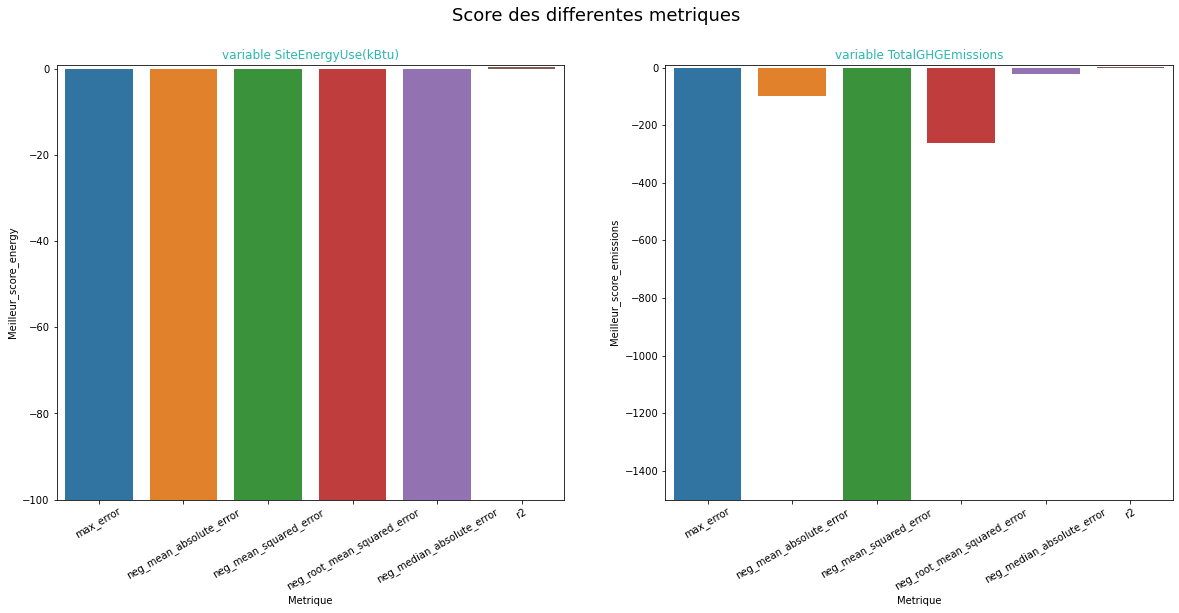

In [99]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(20,8))
ax=sns.barplot(x="Metrique",y="Meilleur_score_energy",data=df_metrique, ax=axes[0])
axes[0].set_title("variable SiteEnergyUse(kBtu)", color='#2cb7b0' )
axes[0].set_ylim(-1e2, 1)
ax_set=ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)
ax=sns.barplot(x="Metrique",y="Meilleur_score_emissions",data=df_metrique, ax=axes[1])
ax_set=ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)
axes[1].set_ylim(-1500, 10)
title=axes[1].set_title("variable TotalGHGEmissions", color='#2cb7b0')
suptitle=fig.suptitle('Score des differentes metriques',fontsize=18)

La metrique R² est celle qui fournie les meilleurs scores,nous allons donc comparer les autres algoritmnes de regression avec cette métrique.

### Comparaison des  differents modèles de regression

Nous allons comparer les differents models de regression sur les données d'entrainement:

Listons les differents models de regression, à noter que le modèle VotingRegressor sera utilisé sur les modèles lineaires:

In [100]:
algos = {
    'LinearRegression' : make_pipeline(
        preprocessor,
        TransformedTargetRegressor(regressor=LinearRegression(), func=np.log1p, inverse_func=np.expm1)
    ),
   'Ridge' : make_pipeline(
        preprocessor,
        TransformedTargetRegressor(regressor=Ridge(), func=np.log1p, inverse_func=np.expm1)
    ),
    'Lasso' : make_pipeline(
        preprocessor,
        TransformedTargetRegressor(regressor=Lasso(), func=np.log1p, inverse_func=np.expm1)
    ),
    'ElasticNet' : make_pipeline(
        preprocessor,
        TransformedTargetRegressor(regressor=ElasticNet(), func=np.log1p, inverse_func=np.expm1)
    ),
    'SVR' : make_pipeline(
        preprocessor,
        TransformedTargetRegressor(regressor=SVR(), func=np.log1p, inverse_func=np.expm1)
    ),
    'RandomForestRegressor' : make_pipeline(
        preprocessor,
        TransformedTargetRegressor(regressor=RandomForestRegressor(), func=np.log1p, inverse_func=np.expm1)
    ),
    'BaggingRegressor' : make_pipeline(
        preprocessor,
        TransformedTargetRegressor(regressor=BaggingRegressor(), func=np.log1p, inverse_func=np.expm1)
    ),
    'AdaBoostRegressor' : make_pipeline(
        preprocessor,
        TransformedTargetRegressor(regressor=AdaBoostRegressor(), func=np.log1p, inverse_func=np.expm1)
    ),
    'SGDRegressor' : make_pipeline(
       preprocessor,
       TransformedTargetRegressor(regressor=SGDRegressor(eta0=0.001), func=np.log1p, inverse_func=np.expm1)
    ),
    'XGBRegressor' : make_pipeline(
        preprocessor,
        TransformedTargetRegressor(regressor=XGBRegressor(), func=np.log1p, inverse_func=np.expm1)
    ),
    'VotingRegressor' : make_pipeline(
     preprocessor,
        TransformedTargetRegressor(regressor=VotingRegressor(estimators=[('lin', LinearRegression()), 
                                  ('ridge', Ridge()), ('lasso', Lasso()),('elnet',ElasticNet()),
                                                           ('svr',SVR()),('sgr',SGDRegressor(eta0=0.001))
                                                                        ]),
                                  func=np.log1p, inverse_func=np.expm1)
    )
}

Définissons une fonction qui calcul les scores des differents models de regression au travers d'une validation croisée sur le jeu de d'entrainement:

In [101]:
def results_r2(target):
    cross_validation = KFold(10, random_state=1, shuffle=True)
    results = {} 
    for name, model in algos.items():
        results[name]= cross_val_score(model, X_train, y_train[target], cv=cross_validation, scoring='r2')
    return pd.DataFrame(results)

#### TotalGHGEmissions

Calculons les scores obtenus pour les émissions de CO2:

In [102]:
results_emissions=results_r2('TotalGHGEmissions')

Vissualisons les resultats:

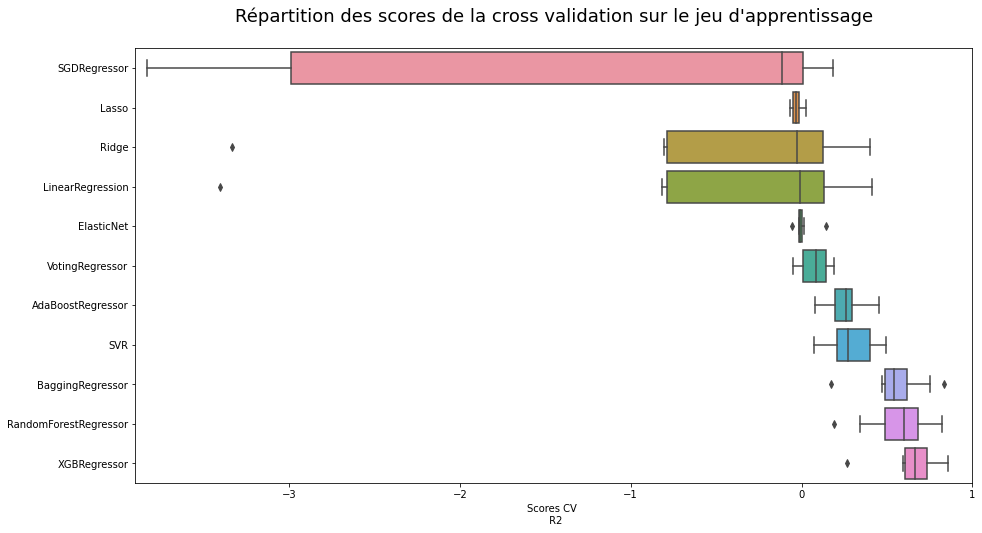

In [251]:
ordre = results_emissions.median().sort_values().index
plt.figure(figsize=(15,8))
ax=sns.boxplot(data = results_emissions[ordre],orient='h', showfliers=True)
ax.set_xlabel("Scores CV \n R2")
plt.xlim(-3.9,1)
title=plt.title("Répartition des scores de la cross validation sur le jeu d'apprentissage" "\n", fontsize=18)

#### SiteEnergyUse(kBtu)

Calculons les scrores obtenus pour la consommation d'énergie:

In [104]:
results_energy=results_r2('SiteEnergyUse(kBtu)')

Vissualisons les resultats:

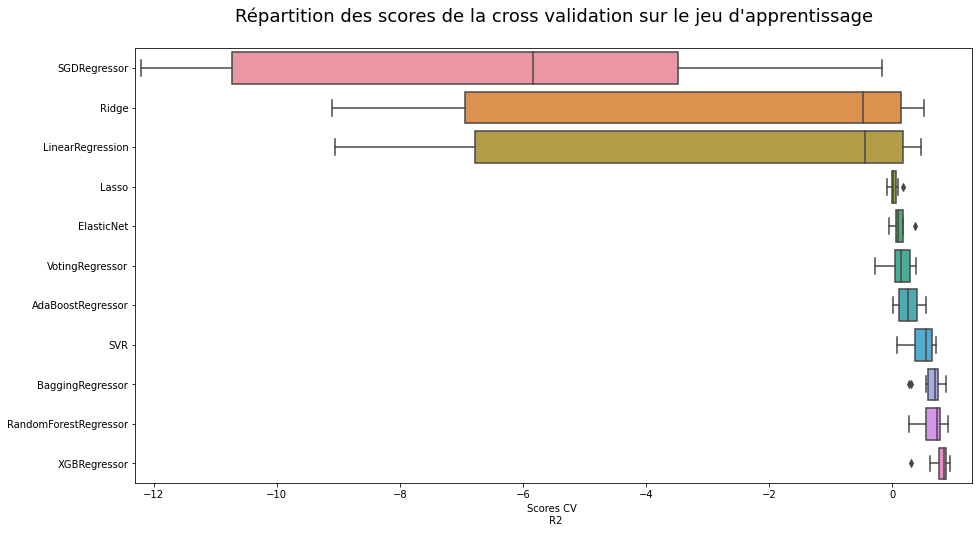

In [257]:
ordre = results_energy.median().sort_values().index

plt.figure(figsize=(15,8))
ax=sns.boxplot(data=results_energy[ordre], orient='h',showfliers=True)
ax.set_xlabel("Scores CV \n R2")
plt.xlim(-12.3,1.3)
title=plt.title("Répartition des scores de la cross validation sur le jeu d'apprentissage" "\n", fontsize=18)

###  Sélection des  modèles

Les modèles linéaires retournent de moins bons scores en général. 

Les modèles linéaires  non-linéaires suivant:
- XGBRegressor
- RandomForestRegressor
- BaggingRegressor 

offrent de meilleurs performances et des scores en moyenne à peu près similaires.

Nous essayerons d'optimiser ces modèles au travers d'une validation croisée pour le choix des meilleurs parametres.

### Optmisation  des modèles choisis : choix des hyperamètres 

Définissons le dataframe des resultats:

In [1]:
def model_scores(pip,step):
    '''This function creates a dataframe of the gridsearch cross validation results'''
    df_results = pd.DataFrame.from_dict(pip.named_steps[step].cv_results_).sort_values('rank_test_score')
    return df_results

#### RandomForestRegressor

Affichons les resultat R2 actuels pour les emissions et la consommation d'énergie:

In [107]:
results_emissions[['RandomForestRegressor']].mean()

RandomForestRegressor    0.56787
dtype: float64

In [218]:
results_energy[['RandomForestRegressor']].mean()

RandomForestRegressor    0.646418
dtype: float64

Listons les paramètres à optimiser:

In [109]:
parameters = {
    'regressor__n_estimators' : [5,15,50],
    'regressor__min_samples_leaf' : [1,3,5,10],
    'regressor__max_features': ['auto', 'sqrt'],
    'regressor__max_depth': [5, 15, 25, 50],
    }
cross_validation = KFold(10, random_state=1, shuffle=True)
rfr_grid_cv = Pipeline([
    ('preprocessor', preprocessor),
    ('grid_search_rfr', GridSearchCV(
                            TransformedTargetRegressor(
                                regressor=RandomForestRegressor(), 
                                func=np.log1p,
                                inverse_func=np.expm1),
                            param_grid=parameters,
                            cv=cross_validation,
                           scoring='r2',
                            n_jobs = -1))])

Affichons les résultats de la validation croisée avec le choix des meilleurs paramètres pour les émissions de CO2:

In [174]:
emiss_rfr_model = rfr_grid_cv.fit(X_train, y_train['TotalGHGEmissions'])
emiss_rfr_results = model_scores(emiss_rfr_model, 'grid_search_rfr')
emiss_rfr_best_r2 = emiss_rfr_model.named_steps['grid_search_rfr'].best_score_
emiss_rfr_best_params = emiss_rfr_model.named_steps['grid_search_rfr'].best_params_
print("Prediction pour 'TotalGHGEmissions' :\nMeilleur Score R2 : {}\nMeilleurs paramètres : {}\n"\
      .format(round(emiss_rfr_best_r2,3), emiss_rfr_best_params))

Prediction pour 'TotalGHGEmissions' :
Meilleur Score R2 : 0.617
Meilleurs paramètres : {'regressor__max_depth': 15, 'regressor__max_features': 'auto', 'regressor__min_samples_leaf': 1, 'regressor__n_estimators': 15}



Affichons les résultats de la validation croisée avec le choix des meilleurs paramètres pour la consommation d'énergie:

In [219]:
energy_rfr_model = rfr_grid_cv.fit(X_train, y_train['SiteEnergyUse(kBtu)'])
energy_rfr_results = model_scores(energy_rfr_model, 'grid_search_rfr')
energy_rfr_best_r2 = energy_rfr_model.named_steps['grid_search_rfr'].best_score_
energy_rfr_best_params = energy_rfr_model.named_steps['grid_search_rfr'].best_params_
print("Prediction pour 'SiteEnergyUse(kBtu)' :\nMeilleur Score R2 : {}\nMeilleurs paramètres : {}\n"\
      .format(round(energy_rfr_best_r2,3), energy_rfr_best_params))

Prediction pour 'SiteEnergyUse(kBtu)' :
Meilleur Score R2 : 0.653
Meilleurs paramètres : {'regressor__max_depth': 15, 'regressor__max_features': 'auto', 'regressor__min_samples_leaf': 1, 'regressor__n_estimators': 50}



#### BaggingRegressor

Affichons les resultats R2 actuels pour les émissions et la consommation d'énergie:

In [119]:
results_emissions[['BaggingRegressor']].mean()

BaggingRegressor    0.550197
dtype: float64

In [120]:
results_energy[['BaggingRegressor']].mean()

BaggingRegressor    0.630638
dtype: float64

Listons les parametres à optimiser:

In [47]:
parameters = {'regressor__base_estimator':[LinearRegression(),SVR(),DecisionTreeRegressor()],
              'regressor__n_estimators' : [100, 200, 300],
               'regressor__bootstrap' : [True, False]}
br_grid_cv = Pipeline([
    ('preprocessor', preprocessor),
    ('grid_search_br', GridSearchCV(
                            TransformedTargetRegressor(
                                regressor=BaggingRegressor(), 
                                func=np.log1p,
                                inverse_func=np.expm1),
                            param_grid=parameters,
                            cv=cross_validation,
                           scoring='r2',
                            n_jobs = -1))])

Affichons les résultats de la validation croisée avec le choix des meilleurs paramètres pour les emissions de CO2:

In [48]:
emiss_br_model = br_grid_cv.fit(X_train, y_train['TotalGHGEmissions'])
emiss_br_results = model_scores(emiss_br_model, 'grid_search_br')
emiss_br_best_r2 = emiss_br_model.named_steps['grid_search_br'].best_score_
emiss_br_best_params = emiss_br_model.named_steps['grid_search_br'].best_params_
print("Prediction pour 'TotalGHGEmissions' :\nMeilleur Score R2 : {}\nMeilleurs paramètres : {}\n"\
      .format(round(emiss_br_best_r2,3), emiss_br_best_params))

Prediction pour 'TotalGHGEmissions' :
Meilleur Score R2 : 0.646
Meilleurs paramètres : {'regressor__base_estimator': DecisionTreeRegressor(), 'regressor__bootstrap': True, 'regressor__n_estimators': 200}



Affichons les résultats de la validation croisée avec le choix des meilleurs paramètres pour la consommation d'énergie:

In [49]:
energy_br_model = br_grid_cv.fit(X_train, y_train['SiteEnergyUse(kBtu)'])
energy_br_results = model_scores(energy_br_model, 'grid_search_br')
energy_br_best_r2 = energy_br_model.named_steps['grid_search_br'].best_score_
energy_br_best_params = energy_br_model.named_steps['grid_search_br'].best_params_
print("Prediction pour 'SiteEnergyUse(kBtu)' :\nMeilleur Score R2 : {}\nMeilleurs paramètres : {}\n"\
      .format(round(energy_br_best_r2,3), energy_br_best_params))

Prediction pour 'SiteEnergyUse(kBtu)' :
Meilleur Score R2 : 0.646
Meilleurs paramètres : {'regressor__base_estimator': DecisionTreeRegressor(), 'regressor__bootstrap': True, 'regressor__n_estimators': 300}



#### XGBRegressor

Affichons les resultat R2 actuels pour les émissions et la consommation d'energie:

In [121]:
results_emissions[['XGBRegressor']].mean()

XGBRegressor    0.653784
dtype: float64

In [122]:
results_energy[['XGBRegressor']].mean()

XGBRegressor    0.774183
dtype: float64

Listons les parametres à optimiser:

In [58]:
parameters = {'regressor__learning_rate' : [0.001, 0.01, 0.2],
             'regressor__gamma': [0, 0.25, 1.0],
             'regressor__max_depth': [6, 15, 20],
             'regressor__n_estimators': [ 100, 200, 1000],
              'regressor__reg_lambda': [1.0, 2.0, 5.0],
              'regressor__reg_alpha': [0, 1.0, 3.0]
    }
xgr_grid_cv = Pipeline([
    ('preprocessor', preprocessor),
    ('grid_search_xgr', GridSearchCV(
                            TransformedTargetRegressor(
                                regressor=XGBRegressor(), 
                                func=np.log1p,
                                inverse_func=np.expm1),
                            param_grid=parameters,
                            cv=cross_validation,
                            scoring='r2',
                            n_jobs = -1))])

Affichons les résultats de la validation croisée avec le choix des meilleurs paramètres pour les emissions de CO2:

In [59]:
emiss_xgr_model = xgr_grid_cv.fit(X_train, y_train['TotalGHGEmissions'])
emiss_xgr_results = model_scores(emiss_xgr_model, 'grid_search_xgr')
emiss_xgr_best_r2 = emiss_xgr_model.named_steps['grid_search_xgr'].best_score_
emiss_xgr_best_params = emiss_xgr_model.named_steps['grid_search_xgr'].best_params_
print("Prediction pour 'TotalGHGEmissions' :\nMeilleur Score R2 : {}\nMeilleurs paramètres : {}\n"\
      .format(round(emiss_xgr_best_r2,3), emiss_xgr_best_params))

Prediction pour 'TotalGHGEmissions' :
Meilleur Score R2 : 0.779
Meilleurs paramètres : {'regressor__gamma': 0, 'regressor__learning_rate': 0.2, 'regressor__max_depth': 15, 'regressor__n_estimators': 1000, 'regressor__reg_alpha': 0, 'regressor__reg_lambda': 2.0}



Affichons les résultats de la validation croisée avec le choix des meilleurs paramètres pour la consommation d'énergie:

In [60]:
energy_xgr_model = xgr_grid_cv.fit(X_train, y_train['SiteEnergyUse(kBtu)'])
energy_xgr_results = model_scores(energy_xgr_model, 'grid_search_xgr')
energy_xgr_best_r2 = energy_xgr_model.named_steps['grid_search_xgr'].best_score_
energy_xgr_best_params = energy_xgr_model.named_steps['grid_search_xgr'].best_params_
print("Prediction pour 'SiteEnergyUse(kBtu)' :\nMeilleur Score R2 : {}\nMeilleurs paramètres : {}\n"\
      .format(round(energy_xgr_best_r2,3), energy_xgr_best_params))

Prediction pour 'SiteEnergyUse(kBtu)' :
Meilleur Score R2 : 0.781
Meilleurs paramètres : {'regressor__gamma': 0.25, 'regressor__learning_rate': 0.2, 'regressor__max_depth': 6, 'regressor__n_estimators': 200, 'regressor__reg_alpha': 0, 'regressor__reg_lambda': 1.0}



### Comparaison des modèles choisis

 Nous allons comparer les differents scores des modèles et les temps d'entrainement et de prédiction.

Définissons le dataframe des resultats des scores et des temps pour les émissions et la consommation d'énergie:

In [226]:
df_results_emissions = pd.DataFrame({"Time":[emiss_rfr_results['mean_fit_time'].mean(),
                       emiss_rfr_results['mean_score_time'].mean(),emiss_br_results['mean_fit_time'].mean(),
                       emiss_br_results['mean_score_time'].mean(),emiss_xgr_results['mean_fit_time'].mean(),
                                             emiss_xgr_results['mean_score_time'].mean()],
                       "Mean time": ['mean_fit_time', 'mean_score_time','mean_fit_time', 'mean_score_time',
                                'mean_fit_time', 'mean_score_time'],
                      "Score R2": [emiss_rfr_best_r2, emiss_rfr_best_r2,emiss_br_best_r2, emiss_br_best_r2,
                                emiss_xgr_best_r2, emiss_xgr_best_r2],
                      "Model": ['RandomForestRegressor','RandomForestRegressor','BaggingRegressor',
                         'BaggingRegressor' ,'XGBRegressor','XGBRegressor']})

df_results_energy =pd.DataFrame({"Time":[energy_rfr_results['mean_fit_time'].mean(),
                       energy_rfr_results['mean_score_time'].mean(),energy_br_results['mean_fit_time'].mean(),
                       energy_br_results['mean_score_time'].mean(),energy_xgr_results['mean_fit_time'].mean(),
                                             energy_xgr_results['mean_score_time'].mean()],
                       "Mean time": ['mean_fit_time', 'mean_score_time','mean_fit_time', 'mean_score_time',
                                'mean_fit_time', 'mean_score_time'],
                      "Score R2": [energy_rfr_best_r2, energy_rfr_best_r2,energy_br_best_r2, energy_br_best_r2,
                                energy_xgr_best_r2, energy_xgr_best_r2],
                      "Model": ['RandomForestRegressor','RandomForestRegressor','BaggingRegressor',
                         'BaggingRegressor' ,'XGBRegressor','XGBRegressor']})


Affichons le comparatif des scores et des temps des différents models pour les émissions:

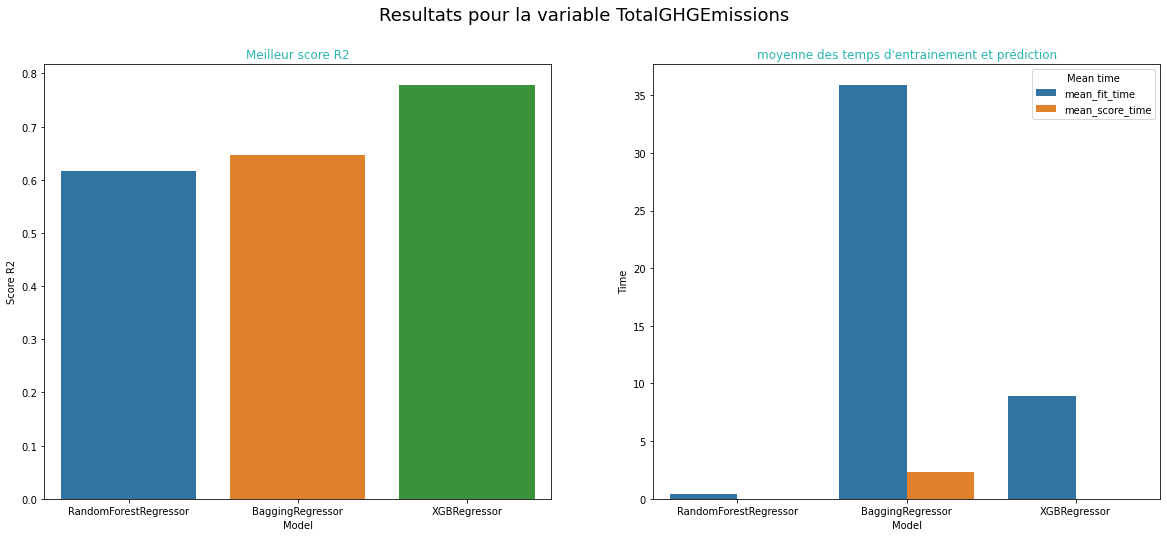

In [227]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(20,8))

ax=sns.barplot(x="Model",y="Score R2",data=df_results_emissions, ax=axes[0])
axes[0].set_title("Meilleur score R2", color='#2cb7b0' )
ax=sns.barplot(x="Model",y="Time",hue="Mean time",data=df_results_emissions, ax=axes[1])
title=axes[1].set_title("moyenne des temps d'entrainement et prédiction", color='#2cb7b0')
suptitle=fig.suptitle('Resultats pour la variable TotalGHGEmissions',fontsize=18)

Affichons le comparatif des scores et des temps des différents models pour la consommation d'énergie:

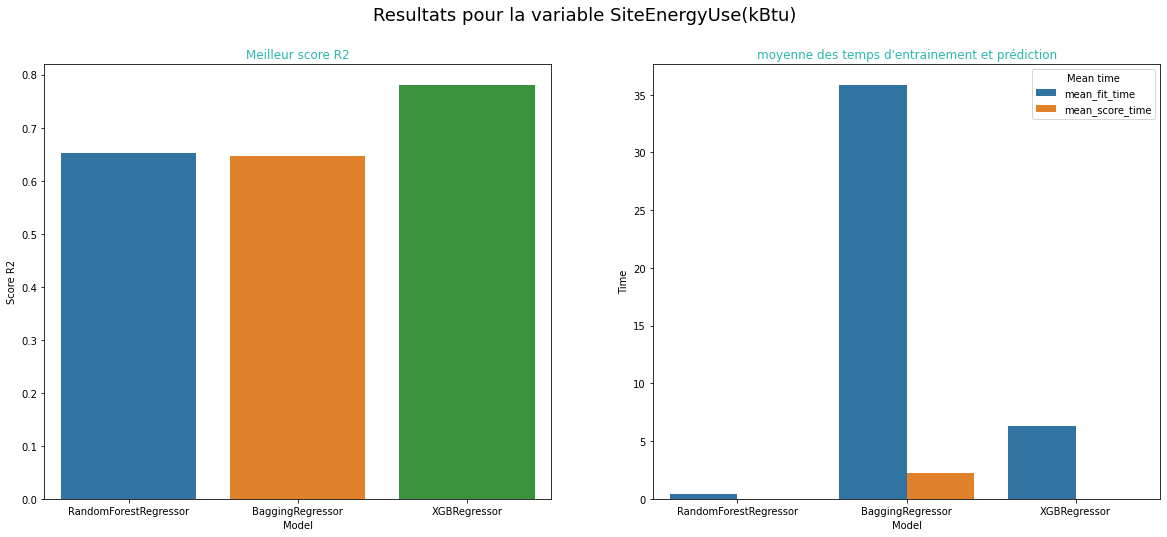

In [228]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(20,8))

ax=sns.barplot(x="Model",y="Score R2",data=df_results_energy, ax=axes[0])
axes[0].set_title("Meilleur score R2", color='#2cb7b0' )
ax=sns.barplot(x="Model",y="Time",hue="Mean time",data=df_results_energy, ax=axes[1])
title=axes[1].set_title("moyenne des temps d'entrainement et prédiction", color='#2cb7b0')
suptitle=fig.suptitle('Resultats pour la variable SiteEnergyUse(kBtu)',fontsize=18)

### Choix définitif du modèle

Nous décidons de tenir en compte du score de la métrique et du temps d'entrainement et prédiction dans le choix définitif du modèle:


Pour classer les modèles,nous définissons ainsi un score tel que:
- Score=[(Temps d'entrainement et prédiction)+(Meilleur score R2)]/ [(Temps d'entrainement et prédiction)X(Meilleur score R2)]



Calculons les temps complessif d'entrainement et prédiction et les meilleurs score R2:

In [229]:
time_rfr_emiss=emiss_rfr_results['mean_fit_time'].mean()+emiss_rfr_results['mean_score_time'].mean()
time_rfr_energy=energy_rfr_results['mean_fit_time'].mean()+energy_rfr_results['mean_score_time'].mean()
time_br_emiss=emiss_br_results['mean_fit_time'].mean()+emiss_br_results['mean_score_time'].mean()
time_br_energy=energy_br_results['mean_fit_time'].mean()+energy_br_results['mean_score_time'].mean()
time_xgr_emiss=emiss_xgr_results['mean_fit_time'].mean()+emiss_xgr_results['mean_score_time'].mean()
time_xgr_energy=energy_xgr_results['mean_fit_time'].mean()+energy_xgr_results['mean_score_time'].mean()
score_rfr_emiss=emiss_rfr_best_r2
score_rfr_energy=energy_rfr_best_r2
score_br_emiss=emiss_br_best_r2
score_br_energy=energy_br_best_r2
score_xgr_emiss=emiss_xgr_best_r2
score_xgr_energy=energy_xgr_best_r2

Calculons les scores  relatifs aux différents modèles choisis:

In [230]:
score_rfr_emiss=(time_rfr_emiss+score_rfr_emiss)/(time_rfr_emiss*score_rfr_emiss)
score_rfr_energy=(time_rfr_energy+score_rfr_energy)/(time_rfr_energy*score_rfr_energy)
score_br_emiss=(time_br_emiss+score_br_emiss)/(time_br_emiss*score_br_emiss)
score_br_energy=(time_br_energy+score_br_energy)/(time_br_energy*score_br_energy)
score_xgr_emiss=(time_xgr_emiss+score_xgr_emiss)/(time_xgr_emiss*score_xgr_emiss)
score_xgr_energy=(time_xgr_energy+score_xgr_energy)/(time_xgr_energy*score_xgr_energy)

Définissons le dataframe des résultats des scores pour les émissions:

In [231]:
df_results_score_emiss=pd.DataFrame([['RandomForestRegressor',score_rfr_emiss],['BaggingRegressor',score_br_emiss],
               ['XGBRegressor',score_xgr_emiss]],
            columns=['Model','Score'])
df_results_score_emiss

,Model,Score
0,RandomForestRegressor,3.937795
1,BaggingRegressor,1.574445
2,XGBRegressor,1.395518


Définissons le dataframe des résultats des scores pour la consommation d'énergie:

In [232]:
df_results_score_energy=pd.DataFrame([['RandomForestRegressor',score_rfr_energy],['BaggingRegressor',score_br_energy],
               ['XGBRegressor',score_xgr_energy]],
            columns=['Model','Score'])
df_results_score_energy

,Model,Score
0,RandomForestRegressor,3.745772
1,BaggingRegressor,1.573332
2,XGBRegressor,1.438984


Visualissons les résultats des scores de manière graphique:

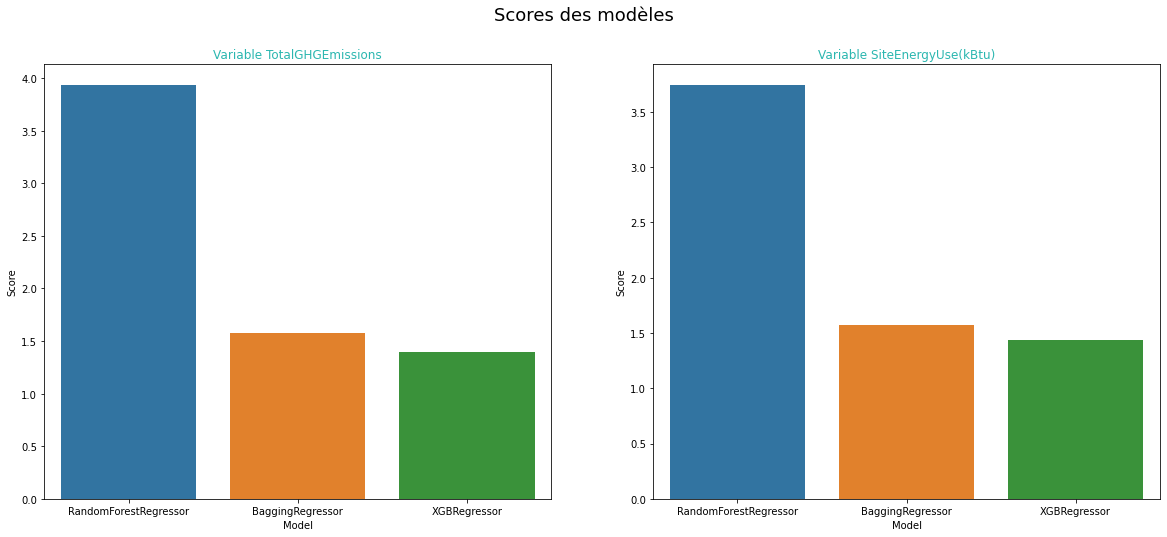

In [233]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(20,8))

ax=sns.barplot(x="Model",y="Score",data=df_results_score_emiss, ax=axes[0])
axes[0].set_title("Variable TotalGHGEmissions", color='#2cb7b0' )
ax=sns.barplot(x="Model",y="Score",data=df_results_score_energy, ax=axes[1])
title=axes[1].set_title("Variable SiteEnergyUse(kBtu)", color='#2cb7b0')
suptitle=fig.suptitle('Scores des modèles',fontsize=18)

#### Modèle retenu

En faisant un compromis entre le meilleur score R2 et temps d'entrainement et de prédiction, il en  ressort que pour le jeu de donnée de notre étude,        le modèle de regression :
- RandomForestRegressor

est le modèle retenu pour les prédictions des émissions de CO2 et de la consommation d'énergie.

### Importance des features

Définissons une fonction qui affiche les features importantes pour le modèle:

In [234]:
def features_importances(model,title):
    feature_importance = model.named_steps['grid_search_rfr'].best_estimator_.regressor_.feature_importances_ 
    ohe = rfr_grid_cv.named_steps['preprocessor'].named_transformers_['categorical']
    feature_names = ohe.get_feature_names(input_features=categorical_features)
    feature_names = np.r_[feature_names, numerical_features]
    df_feature_importance = pd.Series(feature_importance ,index=feature_names)
    std = np.std([
    tree.feature_importances_ for tree in model.named_steps['grid_search_rfr'].best_estimator_.regressor_], axis=0)
    fig, ax = plt.subplots(figsize=(15,12))
    df_feature_importance.plot.bar(yerr=std, ax=ax)
    ax.set_title(title,fontsize=18)
    ax.set_ylabel("Diminution moyenne des impuretés",fontsize=18)
    fig.tight_layout()
    

Affichons les features importantes pour le modèle de prédiction des émissions de CO2:

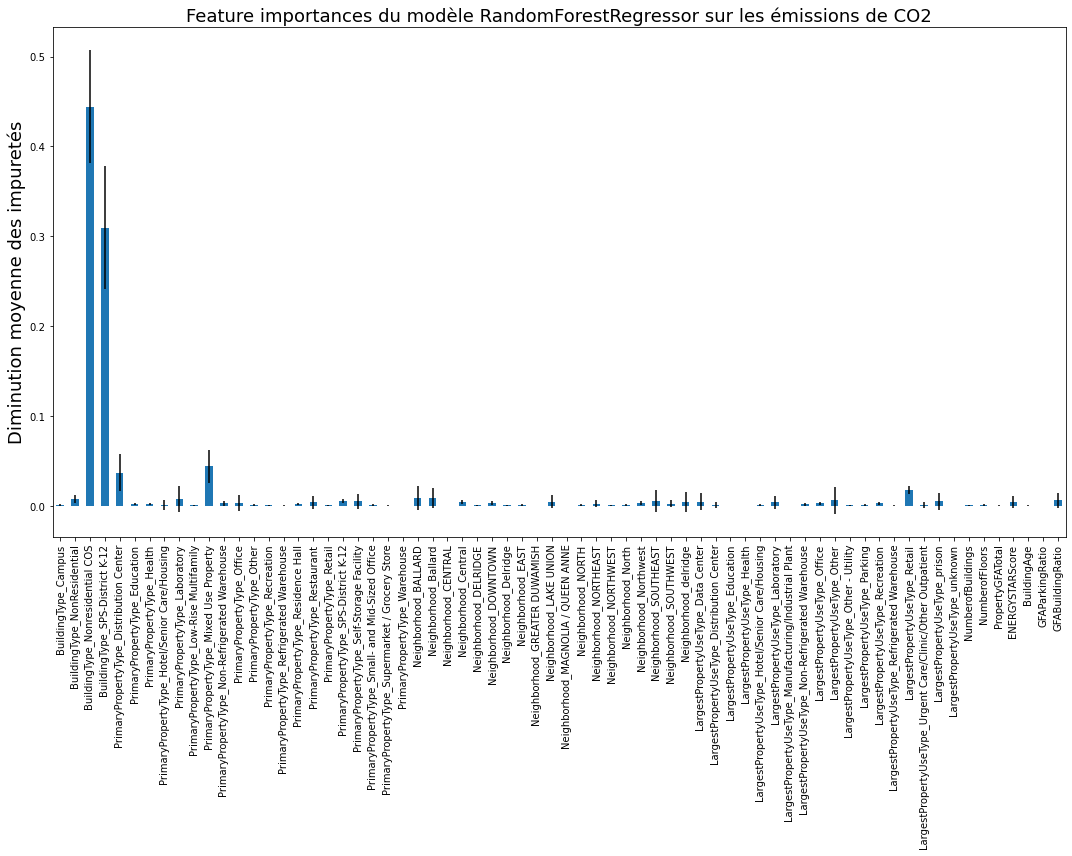

In [235]:
features_importances(emiss_rfr_model,"Feature importances du modèle RandomForestRegressor sur les émissions de CO2")

Affichons les features importantes pour le modèle de prédiction de la consommation d'énergie:

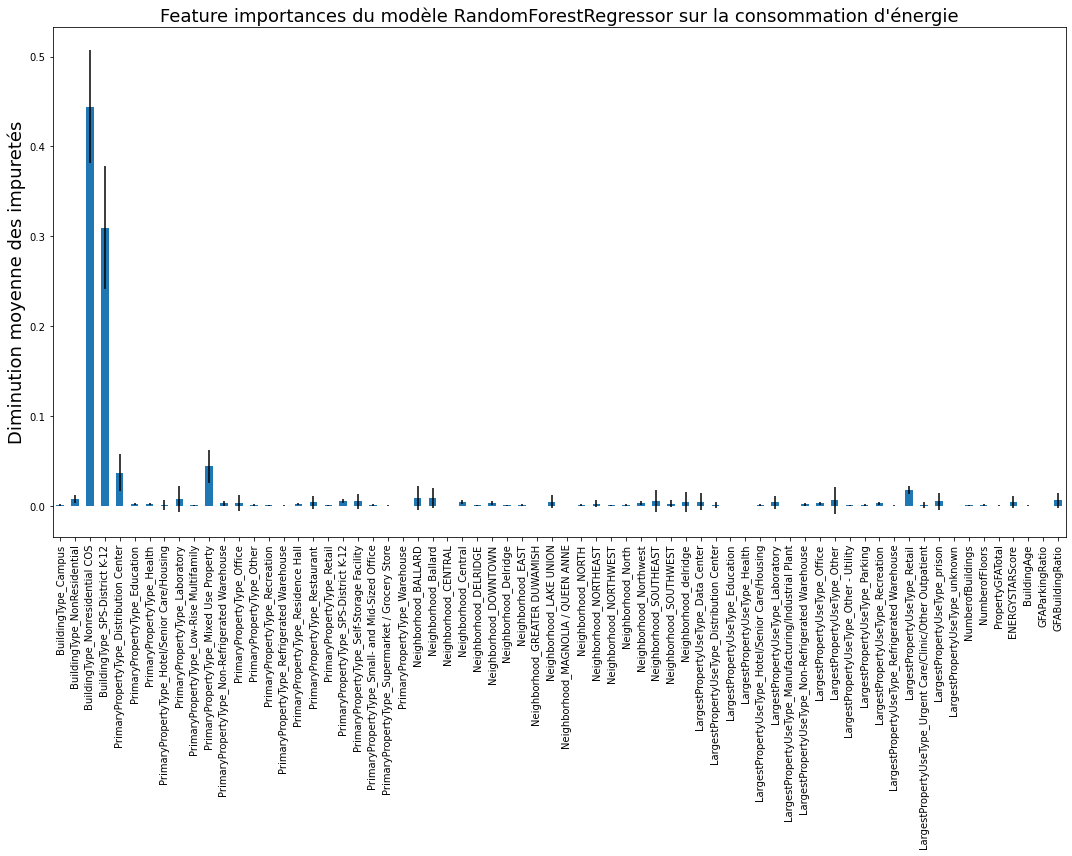

In [236]:
features_importances(energy_rfr_model,"Feature importances du modèle RandomForestRegressor sur la consommation d'énergie")

Les features relatif au type de bâtiments:'BuildingType_Nonresidential COS','BuildingType_SPS-District K-12' et l'utilisation des bâtiments:'PrimaryPropertyType_Distribution Center','PrimaryPropertyType_Mixed Use Property' sont celles ayant un poids plus important dans les décisions de nos deux modèles. En revanche, les features numériques ont un impact très limité.

###  Analyses des prédictions 

Définissons une fonction qui calcul l'erreur entre la valeur prédicte et celle réelle:

In [202]:
def erreur_model(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    err = y_true - y_pred
    mae = np.mean(abs(err))
    r2 = 1-(sum(err**2)/sum((y_true-np.mean(y_true))**2))
    dict_res = {"Valeurs réélles": y_true,"Valeurs prédites":y_pred}
    print("Erreur metrique R2 : {}\nErreur metrique MAE : {}\n".format(r2, mae))
    df_res = pd.DataFrame(dict_res)
    return df_res

Défnissons une fonction pour visualiser les valeurs prédictes et réelles:

In [203]:
def plot_pred_true(y_true, y_pred, df):
    X_plot = [y_true.min(), y_true.max()]
    fig = plt.figure(figsize=(12,8))
    ax=sns.scatterplot(data=df, x="Valeurs réélles", y="Valeurs prédites")
    plt.plot(X_plot, X_plot, color='r')
    ax.set_xlabel("Valeurs réélles")
    ax.set_xlabel("Valeurs prédites")
    plt.title("Valeurs prédites contre valeurs réelles",fontsize=18) 
    plt.show()

### Prédiction des émissions de CO2

Affichons le modèle:

In [204]:
emiss_rfr_model.named_steps['grid_search_rfr'].best_estimator_.regressor_

RandomForestRegressor(max_depth=15, n_estimators=15)

Calculons le temps d'exécution de l'algorithme:

In [205]:
start_time = time.time()

emiss_pred = emiss_rfr_model.predict(X_test)

print("Temps d'execution de l'agorithme : {:.2} s.".format((time.time() - start_time)))

Temps d'execution de l'agorithme : 0.029 s.


In [206]:
emiss_pred = emiss_rfr_model.predict(X_test)

Affichons les résultats des métriques:

In [208]:
emiss_results=erreur_model(y_test['TotalGHGEmissions'],emiss_pred)

Erreur metrique R2 : 0.4562492356414607
Erreur metrique MAE : 93.26976160129634



Affichons les valeurs réelles et prédictes:

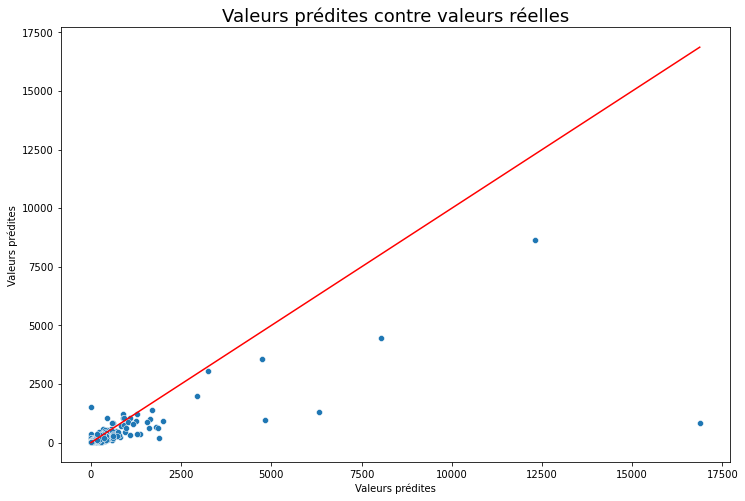

In [210]:
plot_pred_true(y_test['TotalGHGEmissions'],emiss_pred,emiss_results )

Nous obtenons des valeurs prédites assez reserrées sur la première bissectrice et les résultats des métriques sont  assez satisfaisant.

### Prédictions pour la consommation d'énergie

Affichons le modèle:

In [220]:
energy_rfr_model.named_steps['grid_search_rfr'].best_estimator_.regressor_

RandomForestRegressor(max_depth=15, n_estimators=50)

Calculons le temps d'exécution de l'algorithme:

In [221]:
start_time = time.time()

energy_pred = energy_rfr_model.predict(X_test)

print("Temps d'execution de l'agorithme : {:.2} s.".format((time.time() - start_time)))

Temps d'execution de l'agorithme : 0.043 s.


Affichons les résultats des métriques:

In [222]:
energy_results=erreur_model(y_test['SiteEnergyUse(kBtu)'],energy_pred)

Erreur metrique R2 : 0.5277365989743079
Erreur metrique MAE : 3085901.514109217



In [223]:
energy_pred = energy_rfr_model.predict(X_test)

Affichons les valeurs réelles et prédictes:

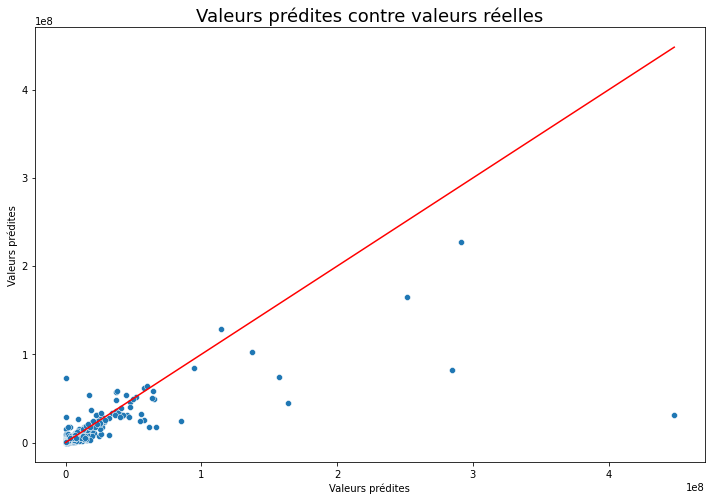

In [225]:
plot_pred_true(y_test['SiteEnergyUse(kBtu)'],energy_pred,energy_results )

Nous obtenons aussi ici des valeurs prédites assez reserrées sur la première bissectrice et des résultats des métriques assez satisfaisant.

### Influence du score ENERGY STAR

Eliminons l'énergie score de nos données d'entrainement et de test:

In [243]:
X_train=X_train.drop(['ENERGYSTARScore'], axis=1)
X_test = X_test.drop(['ENERGYSTARScore'], axis=1)
numerical_features.remove('ENERGYSTARScore')

Définissions le nouveau pipeline:

In [244]:
parameters = {
    'regressor__n_estimators' : [5,15,50],
    'regressor__min_samples_leaf' : [1,3,5,10],
    'regressor__max_features': ['auto', 'sqrt'],
    'regressor__max_depth': [5, 15, 25, 50],
    }
rfr_grid_cv_estar = Pipeline([
    ('preprocessor', preprocessor),
    ('grid_search_rfr_estar', GridSearchCV(
                            TransformedTargetRegressor(
                                regressor=RandomForestRegressor(), 
                                func=np.log1p,
                                inverse_func=np.expm1),
                            param_grid=parameters,
                            cv=cross_validation,
                            scoring='r2'))])

Affichons les résultats de la validation croisée avec le choix des meilleurs paramètres pour les emissions de CO2:

In [245]:
emiss_rfr_model_estar = rfr_grid_cv_estar.fit(X_train, y_train['TotalGHGEmissions'])
emiss_rfr_results_estar = model_scores(emiss_rfr_model_estar, 'grid_search_rfr_estar')
emiss_rfr_best_r2_estar = emiss_rfr_model_estar.named_steps['grid_search_rfr_estar'].best_score_
emiss_rfr_best_params_estar = emiss_rfr_model_estar.named_steps['grid_search_rfr_estar'].best_params_
print("Prediction pour 'TotalGHGEmissions' :\nMeilleur Score R2 : {}\nMeilleurs paramètres : {}\n"\
      .format(round(emiss_rfr_best_r2_estar,3), emiss_rfr_best_params_estar))

Prediction pour 'TotalGHGEmissions' :
Meilleur Score R2 : 0.631
Meilleurs paramètres : {'regressor__max_depth': 25, 'regressor__max_features': 'auto', 'regressor__min_samples_leaf': 1, 'regressor__n_estimators': 5}



####  Prédictions des émissions de CO2:

Affichons les resultats des metriques:

In [246]:
emiss_pred_estar = emiss_rfr_model_estar.predict(X_test)
emiss_results_estar=erreur_model(y_test['TotalGHGEmissions'],emiss_pred_estar)

Erreur metrique R2 : 0.500160007824699
Erreur metrique MAE : 88.84656388787806



Affichons les valeurs réelles et prédictes:

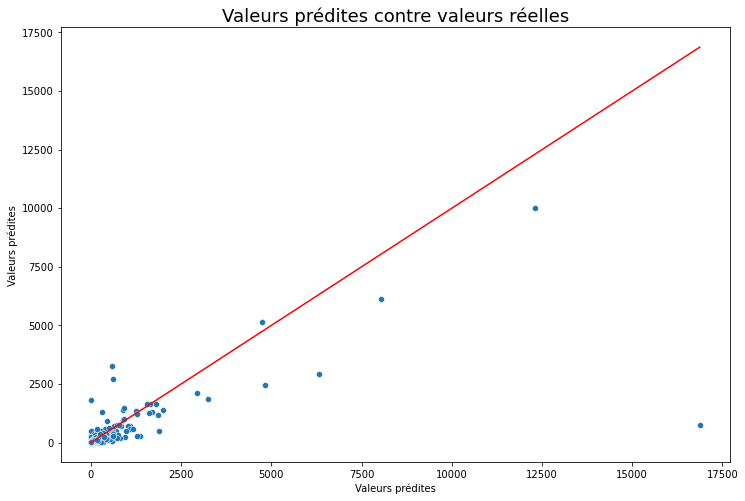

In [247]:
plot_pred_true(y_test['TotalGHGEmissions'],emiss_pred_estar,emiss_results_estar )

### Comparaison des resultats

Affichons les resultats comparatifs pour les emissions de CO2:

In [249]:
df_results_emiss = pd.DataFrame([[ 0.4562492356414607,93.26976160129634],[0.500160007824699,88.84656388787806]],
                          index=['Avec ENERGY STAR','Sans ENERGY STAR'],
                          columns=['R2','MAE'])
df_results_emiss

,R2,MAE
Avec ENERGY STAR,0.456249,93.269762
Sans ENERGY STAR,0.500160,88.846564


Nous observons une légère amélioration des métriques sans la prise en compte de l'ENERGY STAR Score, cette dernière n'a donc pas une influence sur les prédictions.